Same as the first xgboost, but add datetime related features such as month and dayofweek.

Model improves only slightly. 

In [1]:
import numpy as np
import math
import re

import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

data.head(5)

,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


In [3]:
def add_datepart(df, fldname, drop=True, time=False, lower=True):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    if lower: attr = [_.lower() for _ in attr]
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if lower:
        df[targ_pre + 'elapsed'] = fld.astype(np.int64) // 10 ** 9
    else:
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

### Modelling

In [4]:
# initial/dryrun parameters
N = 4  # from last xgboost
seed = 42

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 0.8                # Subsample ratio of the training instance. default = 1
colsample_bytree = 0.8         # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

In [5]:
# functions to wrap lines

def get_mov_avg_std(df, col, N):

    df_out = df.copy()
    df_out[col + '_mean'] = df[col].rolling(window = N, min_periods=1).mean().shift()
    df_out[col + '_std'] = df[col].rolling(window = N, min_periods=1).std().shift()
    
    return df_out


def scale_row(row, feat_mean, feat_std):

    feat_std = 0.001 if feat_std == 0 else feat_std    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=42, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0,
                          name='xgb'):

    model = XGBRegressor(objective='reg:squarederror', # silent=True
                         random_state=seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled * col_std + col_mean

    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred

#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params_tuning(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();

In [6]:
# It is more complicated for LSTM, so I wrapped it into a function
def data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale, features=()):
    """
    cols_to_lag: columns for which lags are added
    cols_to_scale: original columns for which scaling applies for the training set. In this example, cols_to_scale=['adj_close']
    features: the features which will not be scaled, like ('month', 'dayofweek')"""
    
    data = data_copy.copy()

    cols_not_scale = ['date'] + list(features)
    
    # get rolling mean and std, add lags
    for col in cols_to_lag:
        data = get_mov_avg_std(data, col, N)
        for i in range(1, N+1):
            data[f'{col}_lag_{i}'] = data[col].shift(i)
            cols_to_scale.append(f'{col}_lag_{i}')

    # Remove the first N rows which contain NaNs
    data = data[N:]
    
    # Note number of test set decreased by N here, but I prefer to keep the size of the training set
    train = data[:ntrain]
    val = data[ntrain:ntrain+nval]
    train_val = data[:ntrain+nval] # convinient
    test = data[ntrain+nval:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
    train_scaled[cols_not_scale] = train.reset_index()[cols_not_scale]

    # Same for train+val
    scaler_train_val = StandardScaler()
    train_val_scaled = scaler_train_val.fit_transform(train_val[cols_to_scale])
    train_val_scaled = pd.DataFrame(train_val_scaled, columns=cols_to_scale)
    train_val_scaled[cols_not_scale] = train_val.reset_index()[cols_not_scale]

    # Do "local" scaling for val and test
    val_scaled = val[cols_not_scale]
    test_scaled = test[cols_not_scale]
    for col in cols_to_lag:
        feat_list = [f'{col}_lag_{i}' for i in range(1, N+1)]
        # for val
        temp = val.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        val_scaled = pd.concat([val_scaled, temp], axis=1)
        # same for test
        temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        test_scaled = pd.concat([test_scaled, temp], axis=1)

    # column names of the featuers (list), and target, to make all data columns consistent
    features = list(features) + cols_to_scale[1:]
    features.sort()  # xgboost depends on the order of features, when there are ties
    target = cols_to_scale[0]
    
    # Split into X and y
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    X_train_val = train_val[features]
    y_train_val = train_val[target]
    X_test = test[features]
    y_test = test[target]

    X_train_scaled = train_scaled[features]
    y_train_scaled = train_scaled[target]
    X_val_scaled = val_scaled[features]
    X_train_val_scaled = train_val_scaled[features]
    y_train_val_scaled = train_val_scaled[target]
    X_test_scaled = test_scaled[features]
    
    return (scaler, scaler_train_val,
            train, val, train_val, test,
            train_scaled, val_scaled, train_val_scaled, test_scaled,
            X_train, y_train, X_val, y_val, 
            X_train_val, y_train_val, X_test, y_test, 
            X_train_scaled, y_train_scaled, X_val_scaled,
            X_train_val_scaled, y_train_val_scaled, X_test_scaled)

### Feature Engineering

* Difference between high and low of each day
* Difference between open and close of each day


In [7]:
#data['month'] = data.date.dt.month
#data['dayofweek'] = data.date.dt.dayofweek
add_datepart(data, 'date', drop=False)
data.drop(['year', 'week', 'day', 'dayofyear', 'elapsed'], axis=1, inplace=True)  # I think these features will cause 1-on-1 mapping
data.drop(['is_year_start'], axis=1, inplace=True)  # Holiday

# Get difference between high and low of each day
data['range_hl'] = data['high'] - data['low']
data.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
data['range_oc'] = data['open'] - data['close']
data.drop(['open', 'close'], axis=1, inplace=True)

data.head()

data_copy = data.copy()

,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,range_hl,range_oc
0,2014-01-02,5404200,57.439999,1,3,False,False,False,False,False,3.570004,-3.160000
1,2014-01-03,4118700,56.740002,1,4,False,False,False,False,False,2.450001,0.849998
2,2014-01-06,11791700,51.259998,1,0,False,False,False,False,False,3.620003,2.990002
3,2014-01-07,6661900,52.490002,1,1,False,False,False,False,False,1.829998,-0.340000
4,2014-01-08,4930200,51.680000,1,2,False,False,False,False,False,1.480000,0.610001


### Data preprocessing

In [9]:
cols_to_lag = "volume adj_close range_hl range_oc".split()
cols_to_scale = ["adj_close"]
cols_date = "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start is_year_end".split()

(   scaler, scaler_train_val,
    train, val, train_val, test,
    train_scaled, val_scaled, train_val_scaled, test_scaled,
    X_train, y_train, X_val, y_val, 
    X_train_val, y_train_val, X_test, y_test, 
    X_train_scaled, y_train_scaled, X_val_scaled,
    X_train_val_scaled, y_train_val_scaled, X_test_scaled
) = data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale, cols_date)

In [10]:
train.head(2)
val.head(2)
test.head(2)

,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,...,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_mean,range_oc_std,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
4,2014-01-08,4930200,51.680000,1,2,False,False,False,False,False,...,1.829998,3.620003,2.450001,3.570004,0.0850,2.564820,-0.340000,2.990002,0.849998,-3.160000
5,2014-01-09,4159900,52.110001,1,3,False,False,False,False,False,...,1.480000,1.829998,3.620003,2.450001,1.0275,1.405618,0.610001,-0.340000,2.990002,0.849998


,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,...,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_mean,range_oc_std,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
895,2017-07-24,1805100,44.980000,7,0,False,False,False,False,False,...,1.239998,1.720001,1.750000,2.119999,-0.347501,0.885639,0.879997,-0.420002,-0.629997,-1.220001
896,2017-07-25,2086300,45.459999,7,1,False,False,False,False,False,...,0.779999,1.239998,1.720001,1.750000,0.014999,0.683055,0.230000,0.879997,-0.420002,-0.629997


,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,...,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_mean,range_oc_std,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
1192,2018-09-26,1029600,48.549999,9,2,False,False,False,False,False,...,0.869999,1.000000,0.829998,0.880001,0.102499,0.454414,0.489998,-0.250000,0.50,-0.330002
1193,2018-09-27,926900,48.520000,9,3,False,False,False,False,False,...,1.390003,0.869999,1.000000,0.829998,0.482500,0.588070,1.190002,0.489998,-0.25,0.500000


In [11]:
train_scaled.head(2)
val_scaled.head(2)
test_scaled.head(2)

,adj_close,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,...,range_oc_lag_3,range_oc_lag_4,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end
0,0.070099,1.587583,3.693882,0.519618,1.049789,0.134412,0.035313,0.473860,0.528804,0.038738,...,0.663568,-2.572222,2014-01-08,1,2,False,False,False,False,False
1,0.104584,0.865542,1.571415,3.695062,0.518119,0.069446,0.133973,0.034315,0.472657,-0.298904,...,2.395681,0.663235,2014-01-09,1,3,False,False,False,False,False


,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,volume_lag_1,volume_lag_2,...,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
895,2017-07-24,7,0,False,False,False,False,False,-0.969569,-0.045841,...,0.410948,-1.316610,-1.295494,0.034644,0.117773,1.143077,1.386003,-0.081863,-0.318975,-0.985165
896,2017-07-25,7,1,False,False,False,False,False,-0.893260,-0.608419,...,1.294676,0.262373,-1.291020,-0.288712,0.757183,0.822549,0.314762,1.266366,-0.636847,-0.944282


,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,volume_lag_1,volume_lag_2,...,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
1192,2018-09-26,9,2,False,False,False,False,False,-0.681588,-0.767603,...,-0.197508,0.867305,-0.341267,1.433294,-0.887293,-0.204734,0.852745,-0.775723,0.874756,-0.951778
1193,2018-09-27,9,3,False,False,False,False,False,-0.256471,-0.568371,...,0.847077,0.509596,1.438230,-0.596816,-0.088054,-0.753360,1.203092,0.012750,-1.245600,0.029758


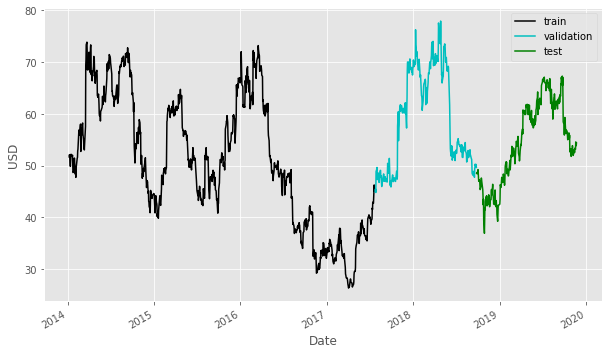

In [12]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

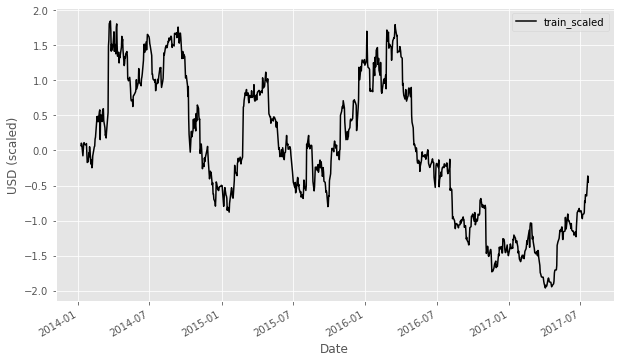

In [13]:
fig,ax=plt.subplots(figsize=(10,6))
ax = train_scaled.plot(x='date', y='adj_close', style='k-', ax=ax)
ax.legend(['train_scaled'])
ax.set_xlabel("Date")
ax.set_ylabel("USD (scaled)")
plt.show();

In [14]:
# Create the model
model = XGBRegressor(objective='reg:squarederror',
                     random_state=seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [15]:
# Do prediction on train set
y_pred_scaled = model.predict(X_train_scaled)
y_pred = y_pred_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

m = forecast_metrics(y_train, y_pred)
print(m)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.014907  1.469101  1.467901  1.447797  0.996685


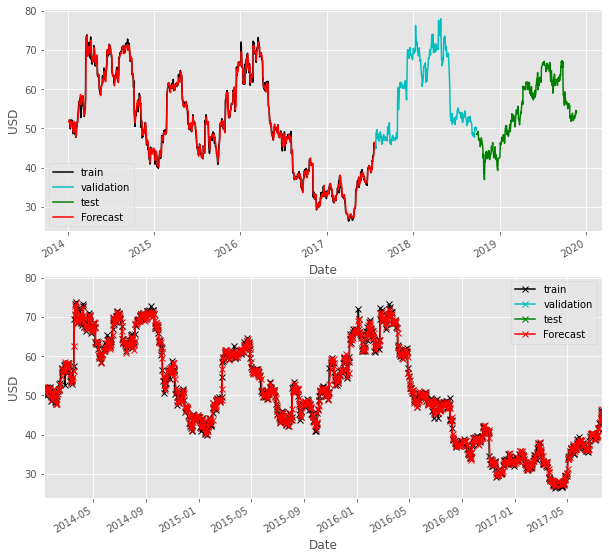

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(train.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(train.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([train.date.min(), train.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [17]:
# Do prediction on val set
y_pred_scaled = model.predict(X_val_scaled)
val['forecast_scaled'] = y_pred_scaled
val['forecast'] = val['forecast_scaled'] * val['adj_close_std'] + val['adj_close_mean']

m = forecast_metrics(y_val, val['forecast'])
print(m)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.619875  1.804922  1.807515  1.772738  0.985498


In [18]:
rmse_dryrun, mape_dryrun = m.RMSE[0], m.MAPE[0]

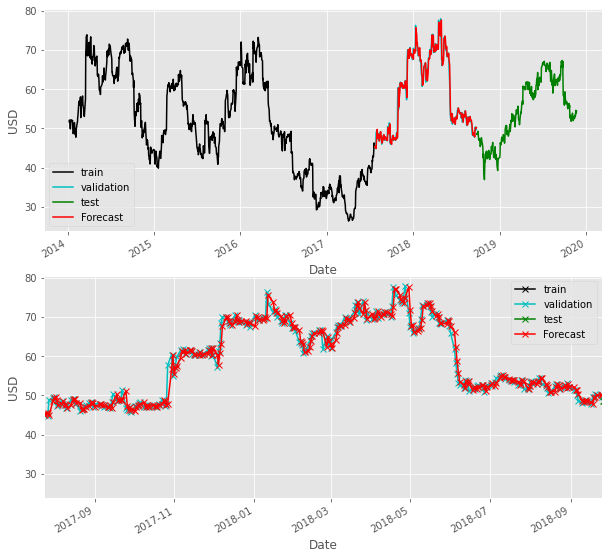

In [19]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, val['forecast'], 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, val['forecast'], 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [20]:
# View a list of the features and their importance scores
imp = list(zip(X_train, model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:][::-1]

[('adj_close_lag_1', 0.69250184),
 ('adj_close_lag_2', 0.22087818),
 ('adj_close_lag_3', 0.048587617),
 ('adj_close_lag_4', 0.004305152),
 ('volume_lag_1', 0.0032077746),
 ('range_oc_lag_1', 0.00288778),
 ('range_oc_lag_3', 0.0028452873),
 ('range_oc_lag_2', 0.0026929118),
 ('range_hl_lag_4', 0.0025875487),
 ('month', 0.0025449444)]

### Tuning N_opt

This will affect the scaling

        RMSE      MAPE     SMAPE    MinMax      Corr
2   1.608277  1.800703  1.804016  1.769576  0.985806
3   1.659093  1.849704  1.852763  1.816270  0.984818
4   1.619875  1.804922  1.807515  1.772738  0.985498
5   1.630943  1.820733  1.823567  1.788247  0.985238
6   1.638648  1.821900  1.825857  1.790121  0.985036
7   1.672484  1.857305  1.861347  1.824349  0.984348
8   1.744314  1.936743  1.941471  1.901319  0.982903
9   1.752273  1.927529  1.930282  1.890157  0.982711
10  1.690370  1.858210  1.861925  1.824478  0.983917
11  1.719497  1.874812  1.877577  1.839014  0.983374
12  1.712800  1.842062  1.845726  1.807442  0.983514
13  1.744322  1.867675  1.871318  1.831631  0.982905
14  1.763057  1.879549  1.883262  1.842776  0.982541
15  1.761179  1.887529  1.891832  1.851321  0.982605
16  1.777754  1.896628  1.899809  1.858409  0.982298
17  1.773789  1.889697  1.893265  1.851923  0.982419
18  1.790594  1.905448  1.907803  1.865630  0.982085
19  1.817191  1.938862  1.942701  1.899224  0.

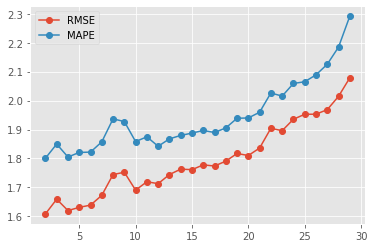

In [22]:
metrics = pd.DataFrame()

for N in range(2,30):
    
    cols_to_lag = "volume adj_close range_hl range_oc".split()
    cols_to_scale = ["adj_close"]
    cols_date = "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start is_year_end".split()

    (   scaler, scaler_train_val,
        train, val, train_val, test,
        train_scaled, val_scaled, train_val_scaled, test_scaled,
        X_train, y_train, X_val, y_val, 
        X_train_val, y_train_val, X_test, y_test, 
        X_train_scaled, y_train_scaled, X_val_scaled,
        X_train_val_scaled, y_train_val_scaled, X_test_scaled
    ) = data_preprocessing(data_copy, N, ntrain, nval, cols_to_lag, cols_to_scale, cols_date)
    
    # Train, predict and eval model
    m, _ = train_pred_eval_model(X_train_scaled, 
                                 y_train_scaled, 
                                 X_val_scaled, 
                                 y_val, 
                                 val['adj_close_mean'],
                                 val['adj_close_std'],
                                 seed=seed,
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=learning_rate, 
                                 min_child_weight=min_child_weight, 
                                 subsample=subsample, 
                                 colsample_bytree=colsample_bytree, 
                                 colsample_bylevel=colsample_bylevel, 
                                 gamma=gamma,
                                 name=N)
    
    # collect metrics
    metrics = metrics.append(m)

print(metrics)
N_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]
metrics[['RMSE', 'MAPE']].plot(style='o-');

In [24]:
# generate the data again

# N_opt = 2 will mostly fall back to the naive model, so I will still use 4 to see the effects of adding date features
N_opt = 4

cols_to_lag = "volume adj_close range_hl range_oc".split()
cols_to_scale = ["adj_close"]
cols_date = "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start is_year_end".split()

(   scaler, scaler_train_val,
    train, val, train_val, test,
    train_scaled, val_scaled, train_val_scaled, test_scaled,
    X_train, y_train, X_val, y_val, 
    X_train_val, y_train_val, X_test, y_test, 
    X_train_scaled, y_train_scaled, X_val_scaled,
    X_train_val_scaled, y_train_val_scaled, X_test_scaled
) = data_preprocessing(data_copy, N_opt, ntrain, nval, cols_to_lag, cols_to_scale, cols_date)

### Tuning xgboost parameters

In [25]:
param_label = 'n_estimators'
param_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)
n_estimators_opt, max_depth_opt = metrics.MAPE.idxmin()

              RMSE      MAPE     SMAPE    MinMax      Corr
(10, 2)   1.729710  1.930930  1.926907  1.887552  0.983644
(10, 3)   1.729851  1.933355  1.928756  1.889445  0.983668
(10, 4)   1.734986  1.940359  1.935762  1.896228  0.983565
(10, 5)   1.738739  1.946344  1.941579  1.901881  0.983486
(10, 6)   1.744400  1.954554  1.949932  1.910022  0.983364
...            ...       ...       ...       ...       ...
(500, 5)  1.625281  1.811145  1.813833  1.778863  0.985388
(500, 6)  1.632066  1.826909  1.829541  1.794277  0.985271
(500, 7)  1.626961  1.821252  1.823767  1.788749  0.985356
(500, 8)  1.625742  1.820764  1.823221  1.788246  0.985387
(500, 9)  1.618370  1.815783  1.818260  1.783649  0.985523

[104 rows x 5 columns]


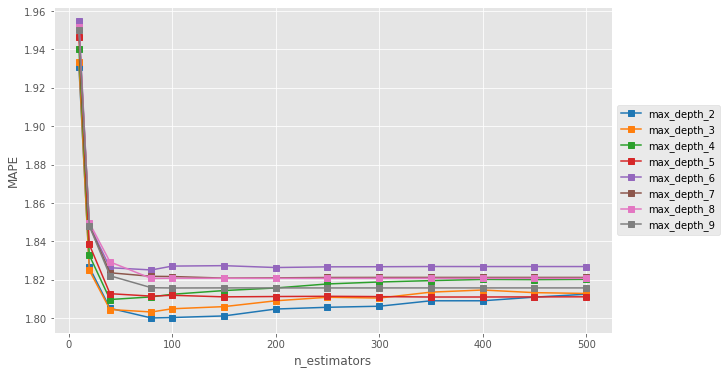

,RMSE,MAPE,SMAPE,MinMax,Corr,n_estimators,max_depth
"(80, 2)",1.61708,1.800125,1.802974,1.768323,0.985547,80,2


In [26]:
plot_two_params_tuning(metrics, param_label, param2_label)
metrics.loc[[metrics.MAPE.idxmin()]]

In [27]:
param_label = 'learning_rate'
param_list = [0.1]  # fixed at first

param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=param2)
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt = 0.1
min_child_weight_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

        RMSE      MAPE     SMAPE    MinMax      Corr
1   1.617080  1.800125  1.802974  1.768323  0.985547
2   1.616716  1.800362  1.803272  1.768636  0.985553
3   1.616714  1.800364  1.803274  1.768638  0.985553
4   1.616952  1.800383  1.803240  1.768593  0.985549
5   1.617127  1.801066  1.803953  1.769295  0.985546
6   1.616422  1.800595  1.803444  1.768819  0.985559
7   1.616273  1.800329  1.803201  1.768582  0.985561
8   1.615682  1.799918  1.802765  1.768163  0.985570
9   1.616144  1.801503  1.804537  1.769916  0.985560
10  1.615981  1.801518  1.804508  1.769894  0.985563
11  1.615331  1.800794  1.803830  1.769237  0.985574
12  1.617002  1.802034  1.804902  1.770248  0.985546
13  1.615187  1.800571  1.803573  1.768994  0.985577
14  1.614748  1.800181  1.803220  1.768660  0.985585
15  1.615447  1.799994  1.802951  1.768365  0.985575
16  1.615821  1.801816  1.804849  1.770243  0.985568
17  1.615033  1.800547  1.803567  1.768993  0.985582
18  1.615046  1.801037  1.804102  1.769538  0.

,RMSE,MAPE,SMAPE,MinMax,Corr
8,1.615682,1.799918,1.802765,1.768163,0.98557


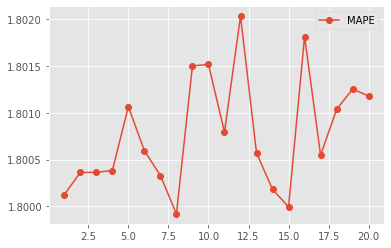

In [28]:
metrics.plot(y=['MAPE'], style='o-');

In [29]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)

param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

subsample_opt, gamma_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.1, 0.1)  1.665279  1.872121  1.876954  1.840278  0.984634
(0.1, 0.2)  1.666611  1.872873  1.878082  1.841346  0.984613
(0.1, 0.3)  1.665131  1.870908  1.876350  1.839700  0.984644
(0.1, 0.4)  1.665141  1.870584  1.876249  1.839619  0.984644
(0.1, 0.5)  1.675209  1.881302  1.886912  1.849856  0.984453
...              ...       ...       ...       ...       ...
(1, 0.6)    1.676239  1.864707  1.868477  1.831389  0.984450
(1, 0.7)    1.677855  1.866332  1.870151  1.832997  0.984420
(1, 0.8)    1.678398  1.867054  1.870852  1.833674  0.984409
(1, 0.9)    1.678079  1.866562  1.870388  1.833226  0.984415
(1, 1)      1.678336  1.866969  1.870808  1.833639  0.984410

[100 rows x 5 columns]


,RMSE,MAPE,SMAPE,MinMax,Corr
"(0.7, 0.1)",1.61087,1.79623,1.79923,1.764806,0.985658


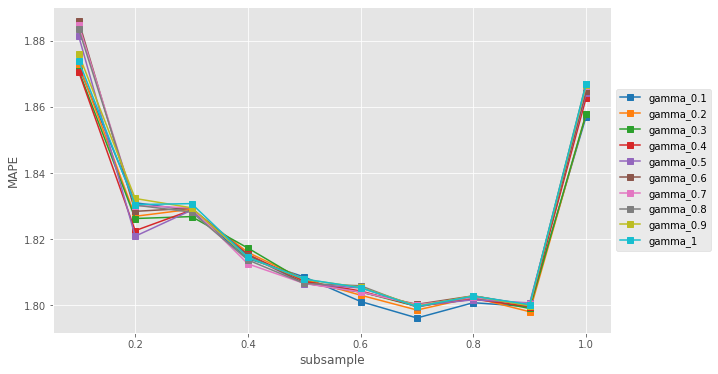

In [30]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [31]:
### Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

colsample_bytree_opt, colsample_bylevel_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.5, 0.5)  1.959156  2.160902  2.166619  2.116765  0.978654
(0.5, 0.6)  1.922959  2.127774  2.132881  2.084744  0.979453
(0.5, 0.7)  1.834988  2.048783  2.052178  2.008051  0.981296
(0.5, 0.8)  1.834774  2.043208  2.046985  2.002887  0.981299
(0.5, 0.9)  1.840760  2.043152  2.048210  2.003781  0.981188
(0.5, 1)    1.759290  1.963051  1.966033  1.925325  0.982842
(0.6, 0.5)  1.913327  2.116226  2.120595  2.072538  0.979691
(0.6, 0.6)  1.909627  2.113387  2.118399  2.070716  0.979757
(0.6, 0.7)  1.836438  2.045048  2.049550  2.005350  0.981274
(0.6, 0.8)  1.832301  2.037769  2.041874  1.997795  0.981380
(0.6, 0.9)  1.761535  1.965180  1.969445  1.928645  0.982784
(0.6, 1)    1.688730  1.885914  1.888867  1.851238  0.984205
(0.7, 0.5)  1.802824  2.009444  2.013754  1.971151  0.981949
(0.7, 0.6)  1.725947  1.919093  1.923228  1.884061  0.983464
(0.7, 0.7)  1.712441  1.906930  1.910534  1.871907  0.983725
(0.7, 0.8)  1.684367  1.

,RMSE,MAPE,SMAPE,MinMax,Corr
"(1, 1)",1.598416,1.785149,1.788802,1.754874,0.985876


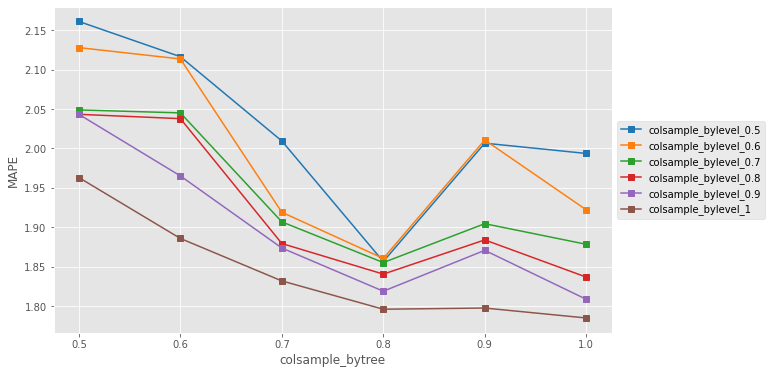

In [32]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [33]:
### Tuning XGBoost - final learning_rate and n_estimators, they should be optimized together

param_label = 'learning_rate'
param_list = [0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

param2_label = 'n_estimators'
param2_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param2, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=colsample_bytree_opt, 
                                     colsample_bylevel=colsample_bylevel_opt, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt, n_estimators_opt = metrics.MAPE.idxmin()
metrics.loc[[metrics.MAPE.idxmin()]]

                  RMSE      MAPE     SMAPE    MinMax      Corr
(0.001, 10)   2.275400  2.537346  2.509448  2.443608  0.973129
(0.001, 20)   2.263968  2.524807  2.497418  2.432197  0.973376
(0.001, 40)   2.241630  2.500106  2.473709  2.409691  0.973856
(0.001, 80)   2.199584  2.453048  2.428502  2.366720  0.974746
(0.001, 100)  2.180057  2.430973  2.407291  2.346535  0.975153
...                ...       ...       ...       ...       ...
(0.3, 300)    1.606518  1.790525  1.794272  1.760013  0.985746
(0.3, 350)    1.603782  1.789470  1.793612  1.759478  0.985790
(0.3, 400)    1.604656  1.790004  1.794195  1.760033  0.985774
(0.3, 450)    1.605063  1.789725  1.793730  1.759552  0.985767
(0.3, 500)    1.602487  1.789006  1.793049  1.759000  0.985811

[117 rows x 5 columns]


,RMSE,MAPE,SMAPE,MinMax,Corr
"(0.1, 400)",1.596038,1.779852,1.783508,1.749696,0.985917


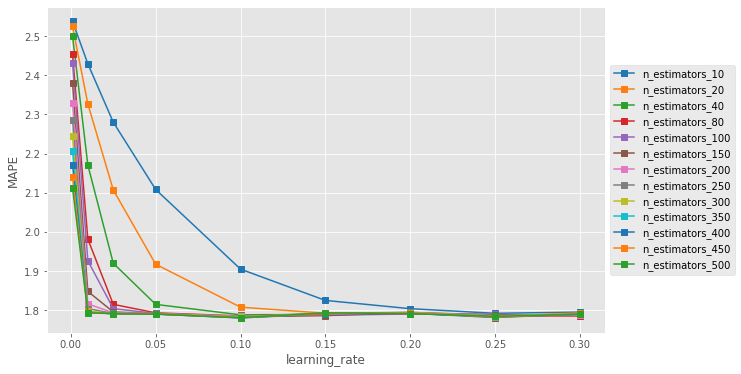

In [34]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [35]:
metrics[metrics.learning_rate==0.1].sort_values(by='MAPE')

,RMSE,MAPE,SMAPE,MinMax,Corr,learning_rate,n_estimators
"(0.1, 400)",1.596038,1.779852,1.783508,1.749696,0.985917,0.1,400.0
"(0.1, 500)",1.596509,1.780575,1.784010,1.750186,0.985910,0.1,500.0
"(0.1, 450)",1.597168,1.780785,1.784231,1.750384,0.985898,0.1,450.0
"(0.1, 350)",1.597065,1.780786,1.784348,1.750492,0.985899,0.1,350.0
"(0.1, 300)",1.598520,1.782565,1.785968,1.752053,0.985875,0.1,300.0
"(0.1, 150)",1.597270,1.782914,1.786620,1.752744,0.985896,0.1,150.0
"(0.1, 250)",1.598802,1.783231,1.786585,1.752657,0.985871,0.1,250.0
"(0.1, 100)",1.597880,1.784002,1.787698,1.753795,0.985885,0.1,100.0
"(0.1, 200)",1.598737,1.784237,1.787838,1.753905,0.985870,0.1,200.0
"(0.1, 80)",1.598416,1.785149,1.788802,1.754874,0.985876,0.1,80.0


### Final model, test set

In [36]:
metrics, y_pred = train_pred_eval_model(X_train_val_scaled, 
                             y_train_val_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt,
                             name='XGBoost')

print(metrics)

             RMSE      MAPE     SMAPE    MinMax     Corr
XGBoost  1.258708  1.750243  1.747043  1.719333  0.98701


### Plotting on test set

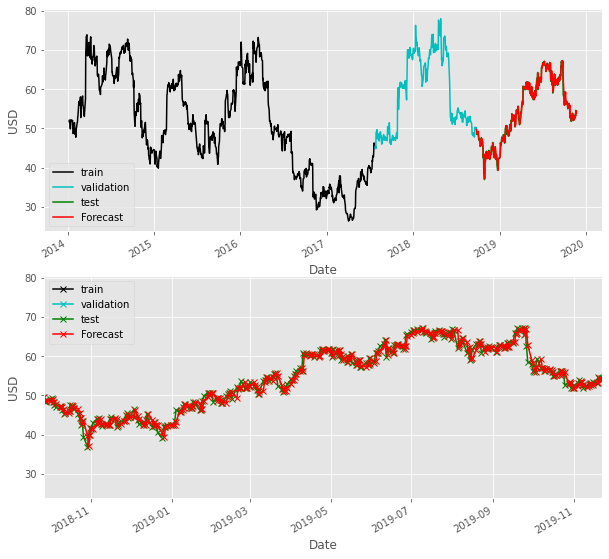

In [37]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [38]:
test[f'forcast'] = y_pred
test.to_csv("./out/test_xgboost_dt.csv")

In [39]:
print(metrics)

             RMSE      MAPE     SMAPE    MinMax     Corr
XGBoost  1.258708  1.750243  1.747043  1.719333  0.98701


In [40]:
# Create the model
model = XGBRegressor(objective='reg:squarederror',
                     seed=seed,
                     n_estimators=n_estimators_opt, 
                     max_depth=max_depth_opt, 
                     learning_rate=learning_rate_opt, 
                     min_child_weight=min_child_weight_opt, 
                     subsample=subsample_opt, 
                     colsample_bytree=colsample_bytree_opt, 
                     colsample_bylevel=colsample_bylevel_opt, 
                     gamma=gamma_opt
                    )

# Train the regressor
model.fit(X_train_val_scaled, y_train_val_scaled)

# Do prediction on val set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled  * test['adj_close_std'] + test['adj_close_mean']

m = forecast_metrics(y_test, y_pred)
print(m)

# View a list of the features and their importance scores
imp = list(zip(X_train.columns, model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-20:][::-1]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=8, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.7, verbosity=1)

          RMSE      MAPE     SMAPE    MinMax     Corr
Algo  1.258708  1.750243  1.747043  1.719333  0.98701


[('adj_close_lag_1', 0.84377897),
 ('adj_close_lag_2', 0.10106567),
 ('adj_close_lag_4', 0.01748258),
 ('range_hl_lag_4', 0.0031806903),
 ('adj_close_lag_3', 0.0030637553),
 ('volume_lag_4', 0.0030467333),
 ('range_hl_lag_2', 0.003027856),
 ('range_oc_lag_3', 0.0027414549),
 ('range_oc_lag_1', 0.002732882),
 ('volume_lag_2', 0.0026381318),
 ('range_hl_lag_3', 0.0025590674),
 ('range_hl_lag_1', 0.0025190068),
 ('month', 0.0024802506),
 ('volume_lag_1', 0.0024724284),
 ('volume_lag_3', 0.0024369345),
 ('range_oc_lag_2', 0.0023926522),
 ('range_oc_lag_4', 0.0023809166),
 ('is_year_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_quarter_end', 0.0)]

In [41]:
# 'month' and 'dayofwork' seems useful